In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
import numpy.polynomial.polynomial as P
import scipy.spatial as spatial
import scipy.ndimage as ndimage
from importlib import reload

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/col-0.tif'
pot_dst = '../pots/'

src, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

dst = pot_dst + bname + '/'

In [7]:
raw = tf.imread(dst + 'airless.tif')

In [4]:
potfiles = sorted(glob.glob(dst + bname + '_pot*.tif'))

potfiles

['../pots/col-0/col-0_pot0.tif',
 '../pots/col-0/col-0_pot1.tif',
 '../pots/col-0/col-0_pot2.tif',
 '../pots/col-0/col-0_pot3.tif']

In [5]:
pot = [None for i in range(len(potfiles))]

for i in range(len(pot)):
    pot[i] = tf.imread(potfiles[i])
    print(np.sum(pot[i] > 0))

5591997
6871190
5633812
2538341


In [6]:
pidx = 1
timg = pot[pidx].copy()
timg, ceros, cerosshape = thales.clean_zeroes(timg)

print(np.max(timg))

87 % reduction from input
131


In [8]:
rawp = raw[ceros].reshape(cerosshape)

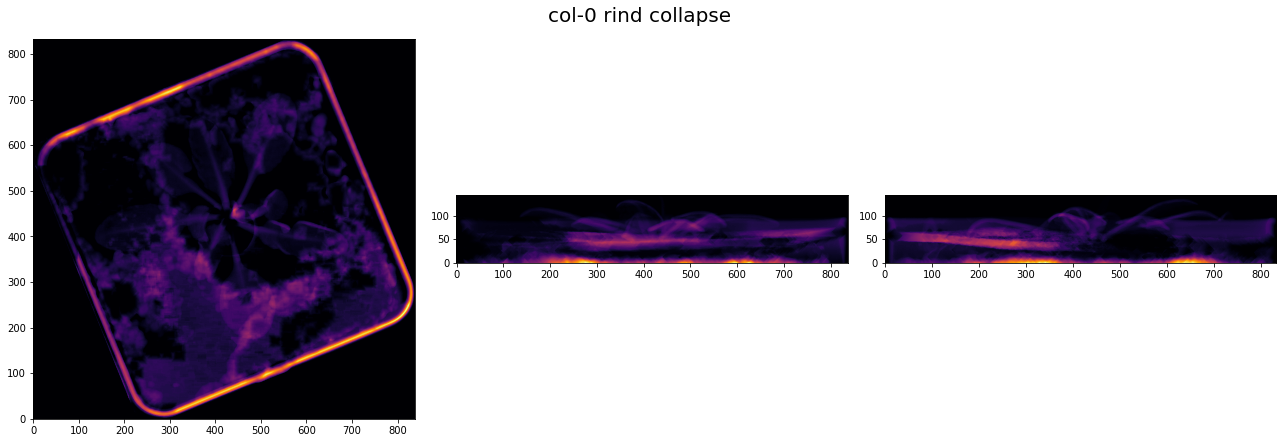

In [9]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(timg)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

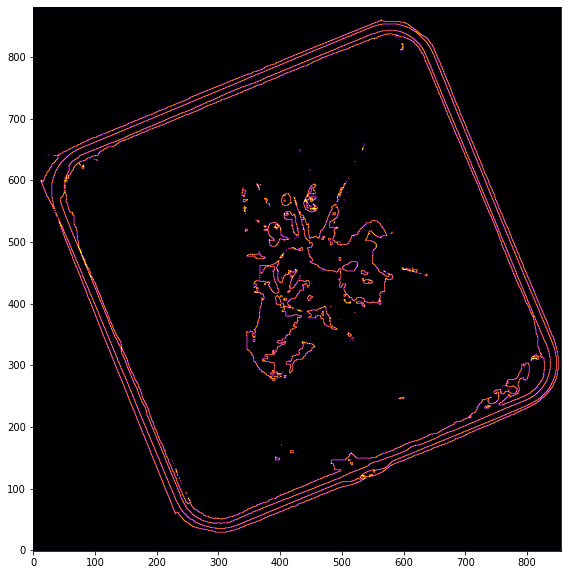

In [8]:
pts = snaps[0].copy()
pts = (255*pts/np.max(pts)).astype(np.uint8).reshape(snaps[0].shape)
pts[pts < 70] = 0
pts[pts > 0] = 1
border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');

In [9]:
corners = thales.four_corners(surface)
tpt, rpt, bpt, lpt = corners
center = np.mean(corners,axis=0)
print('Four corners', tpt, rpt, bpt, lpt, sep='\n')

rhull = np.vstack((lpt,tpt,rpt,bpt,lpt))

Four corners
[884.73023839 624.00125471]
[253.66436637 879.83877039]
[-7.46549561e-02  2.53949184e+02]
[630.99121706  -1.88833124]


In [10]:
bcoefs = thales.four_borderlines(corners)
midpoints = thales.four_midpoints(corners)
mcoefs = thales.midline_splits(midpoints)
centers = thales.four_centers(corners, midpoints)

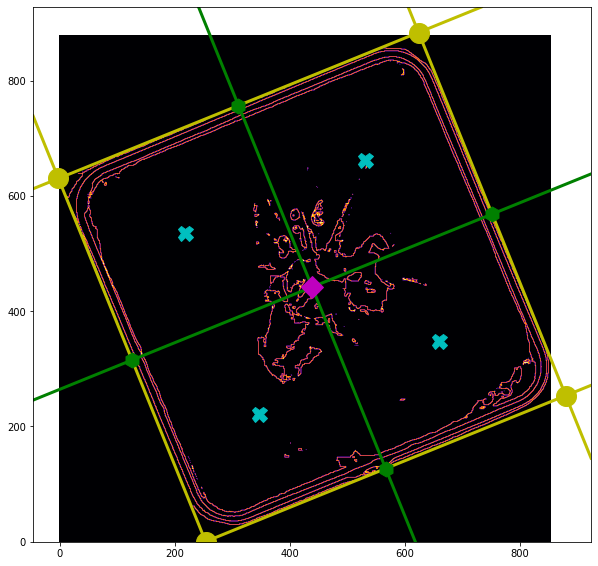

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
for i in range(len(bcoefs)):
    plt.axline(corners[i,:][::-1], slope=bcoefs[i,1], c='y', lw=3)
    plt.plot(corners[i,1], corners[i,0], 'yo', ms=20)
    plt.plot(centers[i,1], centers[i,0], 'cX', ms=15)
    plt.plot(midpoints[i,1], midpoints[i,0], 'gh', ms=15)
for i in range(len(mcoefs)):
    plt.axline(midpoints[i,:][::-1], slope=mcoefs[i,1], c='g', lw=3)

plt.plot(center[1], center[0], 'mD', ms=15);
#plt.savefig('split_pots.jpg', dpi=150, pil_kwargs={'optimize':True})

# Separate connected components

In [10]:
bpot = timg.copy()
bpot[bpot > 0] = 1
levels = np.sum(bpot, axis=(1,2), dtype=int)
diff = np.ediff1d(levels)

In [11]:
import unionfind as UF

pers = sorted(UF.persistence(levels),reverse=True)
print(pers)

[(inf, None, 0), (74114, 23, 45), (5245, 54, 59), (4414, 74, 85), (1137, 120, 129), (534, 58, 57), (0, 138, 139)]


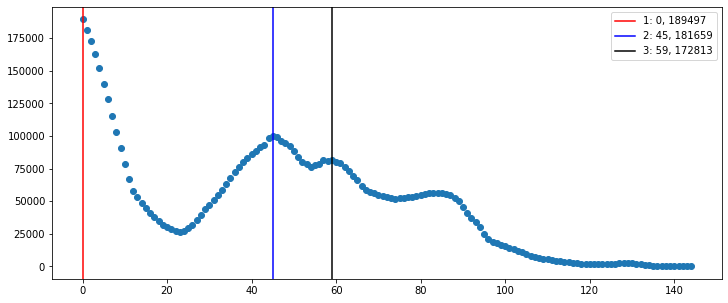

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
color = ['r', 'b', 'k']

ax.scatter(range(len(levels)), levels, linewidths=1);
for i in range(min([3, len(pers)])):
    ax.axvline(x=pers[i][-1], c=color[i], label='{}: {}, {}'.format(i+1, pers[i][-1], levels[i]))
ax.legend();

In [16]:
timg = pot[pidx].copy()
timg = timg[ceros].reshape(cerosshape)
soil_level = pers[1][-1] + 1

timg[:soil_level, :, :] = 0

labels,num = ndimage.label(timg, structure=ndimage.generate_binary_structure(img.ndim, 1))
regions = ndimage.find_objects(labels)
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

171 [1081895  688443  614383  317784    5452    2290    1182     781     630
     579     544     488     424     388     384     373     367     355
     318     268]


In [17]:
cutoff = 1e-2
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(img.ndim, 2)
snaps = []

for j in range(len(regions)):
    i = argsort_hist[j]
    r = regions[i]
    if(hist[i]/sz_hist > cutoff):
        mask = labels[r]==i+1
        box = timg[r].copy()
        box[~mask] = 0
        box[box > 0] = 1
        box = ndimage.binary_dilation(box, structure=struc, iterations=6)
        
        leaf = timg[r]*box
        snap = thales.collapse_dimensions(leaf)
        snaps.append(snap[0])

print('Large components: ', len(snaps))

Large components:  4


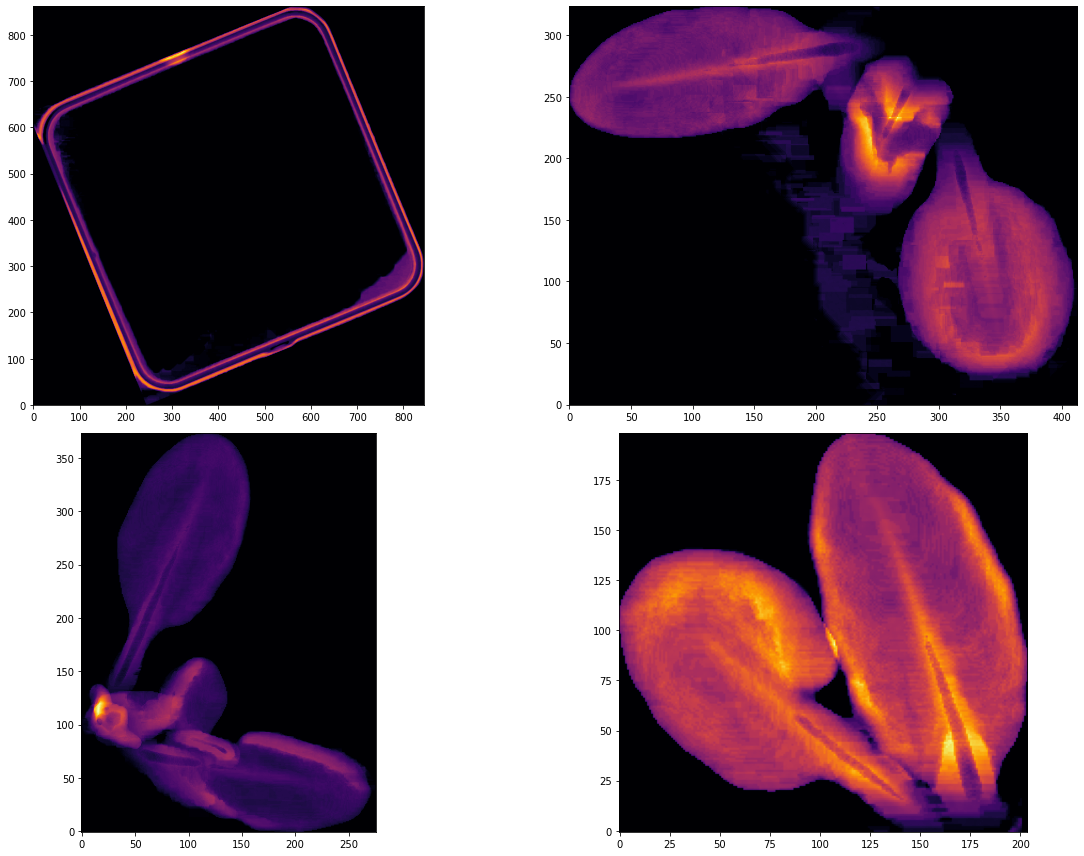

In [18]:
fig, ax = plt.subplots(2,2, figsize=(18,12))

idx = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(snaps[idx], cmap='inferno', origin='lower');
        idx += 1

fig.tight_layout()
plt.savefig('separated_leaves_closeup_{}.jpg'.format(pidx), dpi=150, pil_kwargs={'optimize':True})

In [ ]:
coords = thales.tiff2coords(leaf, False)
print(coords.shape)

In [ ]:
filename = src + bname + '_pot{}.csv'.format(pidx)
print(filename)
np.savetxt(filename, coords, delimiter=',', fmt='%d')

# Get the whole plant

In [21]:
npz = np.hstack(([0],1+np.argsort(argsort_hist)))

with np.nditer(labels, flags=['external_loop'], op_flags=['readwrite']) as it:
    for x in it:
        x[...] = npz[x]

# Break up individual leaves

In [30]:
struc=ndimage.generate_binary_structure(img.ndim, 2)

mask = (labels > 1) & (labels < 5)
box = timg.copy()
box[~mask] = 0
box[box > 0] = 1

box = ndimage.binary_dilation(box, structure=struc, iterations=6)

leaf, lceros, lcerosshape = thales.clean_zeroes(rawp*box)
box = box[lceros].reshape(lcerosshape)
#snaps.append(snap[0])

67 % reduction from input


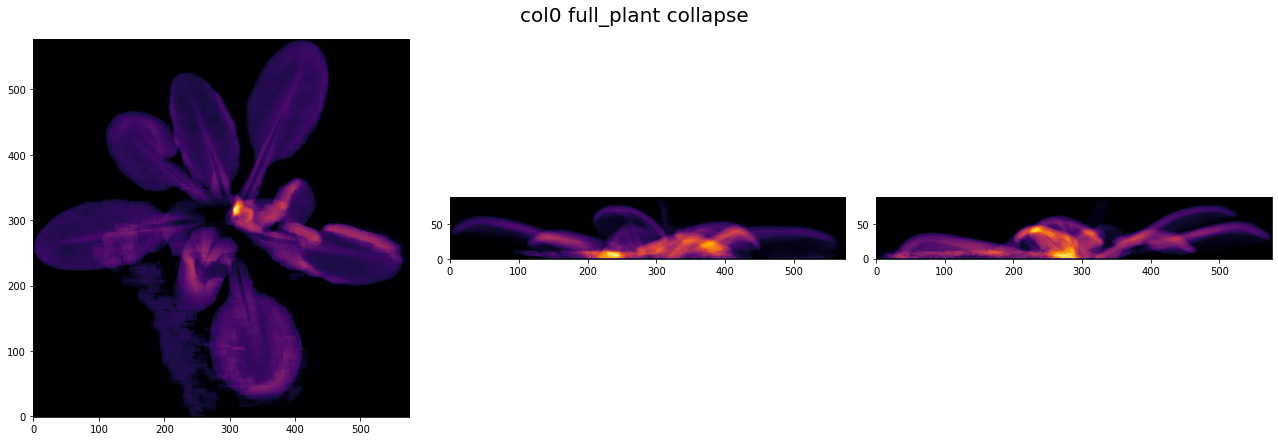

In [53]:
writefig = True
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(leaf)
thales.plot_collapse_dimensions(snaps, bname, 'full_plant', display=display, writefig=writefig, dst=diag_dst)

In [52]:
coords = thales.tiff2coords(leaf, False)
print(coords.shape)

filename = src + bname + '_pot{}.csv'.format(pidx)
print(filename)
np.savetxt(filename, coords+1, delimiter=',', fmt='%d')

(1916816, 3)
arabidopsis/col0_pot1.csv


In [64]:
sigma = 7
#avg = ndimage.gaussian_filter(leaf, sigma=sigma, mode='mirror', truncate=3, cval=0)

size = (15,1,1)
prod = np.product(np.array(size))

avg = ndimage.uniform_filter(leaf, size=size, output = float)
avg = (prod*avg).astype(np.uint)
maxavg = np.max(avg)
print(maxavg)
avg[avg < 0.5*maxavg] = 0

447


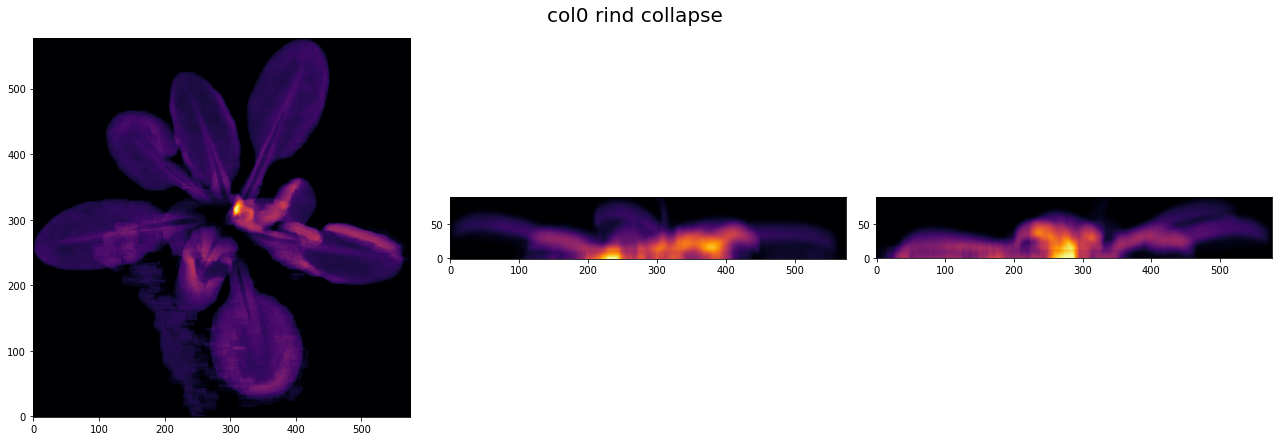

In [58]:
snaps = thales.collapse_dimensions(avg)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

2 2


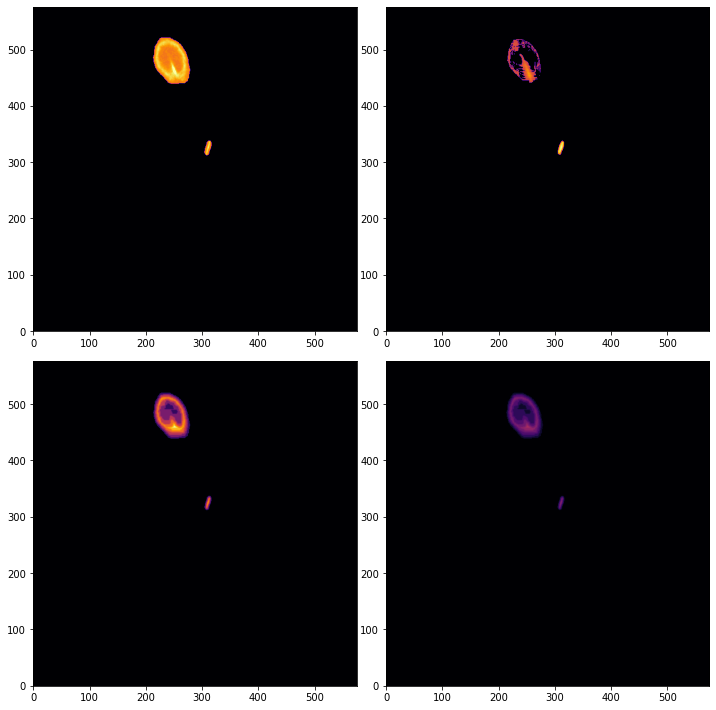

In [83]:
k = 70
ss = np.s_[k,:,:]

thales.plot4x4panel([leaf, avg, dtedt, dtedt], ss, vmax=[30,None,None,13])#, vmax=[150,150,150,150])

In [72]:
dtedt = ndimage.distance_transform_edt(leaf)#, metric='taxicab')
maxd = np.max(dtedt)
print(maxd)

36.0


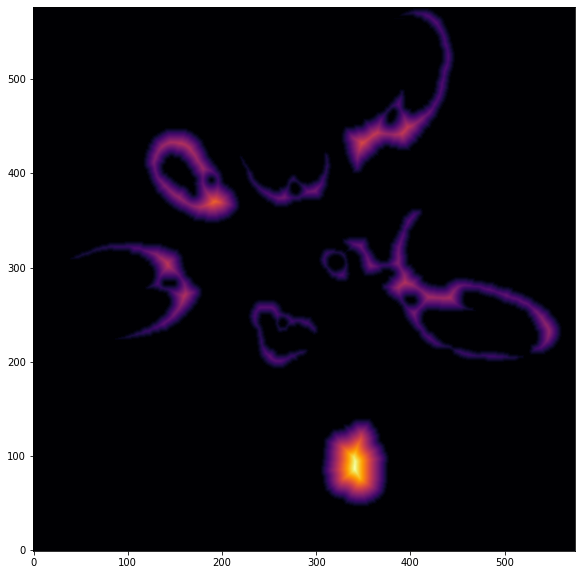

In [79]:
foo = leaf[ss].copy()
foo[foo > 0] = 1
bar = ndimage.distance_transform_edt(foo)
print(bar.max())

plt.figure(figsize=(10,10))
plt.imshow(bar, cmap='inferno', origin='lower');

In [98]:
coords = peak_local_max(bar, footprint=np.ones((3, 3)), labels=foo,
                        min_distance=50, threshold_rel=0.5)
mask = np.zeros(bar.shape, dtype=bool)
mask[tuple(coords.T)] = True
mask = ndimage.binary_dilation(mask, iterations=5)
markers, num = ndimage.label(mask)
print(num, 'components')

5 components


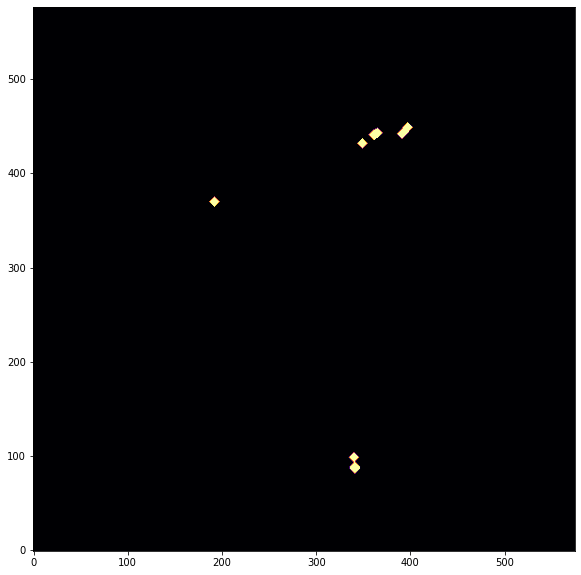

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='inferno', origin='lower');

In [83]:
coords = peak_local_max(dtedt, min_distance=6,
                        threshold_abs=0.8*maxd, footprint=np.ones((3, 3, 3)), 
                        labels=box, exclude_border=False)
print(coords.shape)
print(coords)

(278, 3)
[[  1 112  86]
 [  1 116  84]
 [  3 117  81]
 [  6 119  73]
 [  6 119  74]
 [  6 120  72]
 [  6 120  73]
 [  6 121  72]
 [  6 122  71]
 [  3 122  75]
 [  3 122  74]
 [  3 121  77]
 [  3 121  76]
 [  3 120  78]
 [  3 120  77]
 [  3 119  78]
 [  3 118  79]
 [  5 120  75]
 [  3 117  80]
 [  3 116  81]
 [  7 118  72]
 [  4 119  77]
 [  4 120  76]
 [  4 121  74]
 [  5 120  74]
 [  5 120  73]
 [  5 119  76]
 [  5 121  74]
 [  5 121  75]
 [  5 122  72]
 [  5 122  73]
 [  5 123  71]
 [  5 123  72]
 [  7 120  71]
 [  4 123  73]
 [  4 123  72]
 [  4 122  75]
 [  4 122  74]
 [  4 122  73]
 [  4 121  76]
 [  4 121  75]
 [  3 112  83]
 [  3 111  84]
 [  5 121  73]
 [  3 110  85]
 [  2 110  87]
 [  2 110  86]
 [  3 110  86]
 [  1 119  81]
 [  1 119  80]
 [  1 118  82]
 [  1 118  81]
 [  1 117  82]
 [  1 114  86]
 [  1 114  85]
 [  1 111  88]
 [  0 119  82]
 [  0 119  81]
 [  0 118  83]
 [  0 118  82]
 [  0 114  86]
 [  0 112  88]
 [  2 112  84]
 [  2 113  84]
 [  1 120  79]
 [  2 119  79]
 

In [88]:
mask = np.zeros(dtedt.shape, dtype=bool)
mask[tuple(coords.T)] = True
#mask = ndimage.binary_dilation(mask, iterations=6)

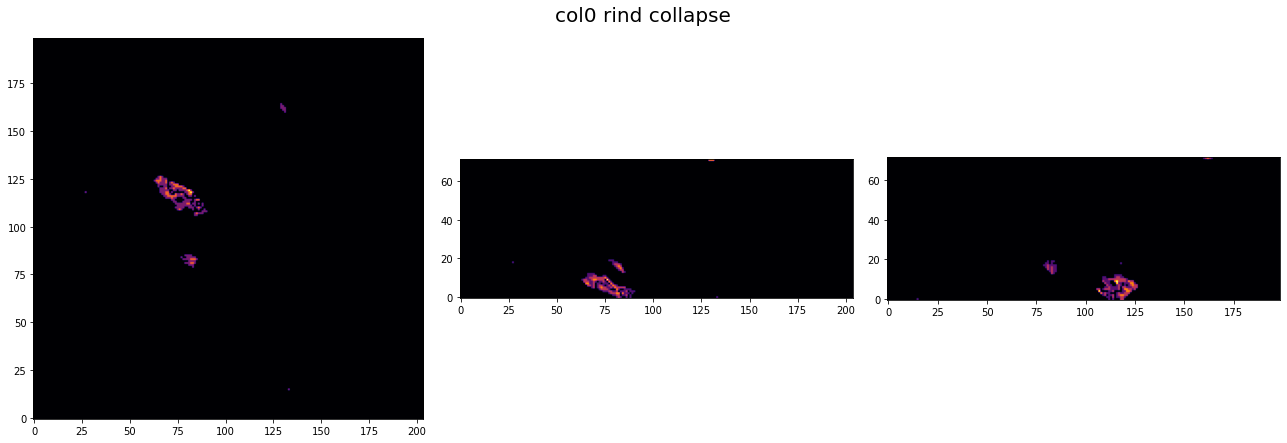

In [89]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(mask)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions(dtcdt > 8)
thales.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [ ]:
np.sum(dtcdt > 10 )

In [ ]:
size = (21,5,5)
prod = np.product(np.array(size))

bvg2 = ndimage.uniform_filter(bavg2, size=size, output = float)
bvg2 = (prod*bvg2).astype(np.uint)
print(prod)

In [ ]:
mimg = timg.copy()
mimg[avg < 15] = 0
mimg[bvg < 275] = 0
mimg[bvg2 < 400] = 0

In [ ]:



# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndimage.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, num = ndimage.label(mask)
print(num, 'labels')
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()

In [ ]:
tuple(coords.T)